In [3]:
!pwd

/home/tromero_client/RL-LRP/testing_sandbox


In [4]:

import sys
sys.path.append('/home/tromero_client/RL-LRP')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from experiments import SimpleRNet, apply_threshold, CosineDistanceLoss, ManualCNN
from matplotlib import pyplot as plt
import numpy as np
# comment out when running locally
from experiments import WrapperNet
# comment out when running locally            

In [5]:
def train_outer_model(wrapped_model, optimizer, criterion, train_loader, device, attention_function):
    total_loss = 0
    wrapped_model.train()
    for _ in range(10):
        data, target = next(iter(train_loader))
        data, target = data.to(device), target.to(device)
        target_map = attention_function(data, threshold=0.95) # threshold is 0.99
        optimizer.zero_grad()
        output = wrapped_model(data, target)
        loss = criterion(output, target_map)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

def test_outer_model(wrapped_model, criterion, test_loader, device, attention_function):
    wrapped_model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_map = attention_function(data, threshold=0.95)
            output = wrapped_model(data, target)
            test_loss += criterion(output, target_map).item()
    test_loss /= len(test_loader.dataset)
    return test_loss    

def plot_heatmap_comparison(wrapped_model, test_loader, device, attention_function, epoch):
    data, target = next(iter(test_loader))
    target_map = attention_function(data, threshold=0.95)
    output = wrapped_model(data.to(device), target.to(device))
    num = np.random.randint(0, len(target))
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(output[num][0].detach().numpy(), cmap='hot')
    axes[0].set_title(f'LRP Output after {epoch} iterations')
    axes[1].imshow(target_map[num][0], cmap='hot')
    axes[1].set_title('Original Image')
    plt.show()

In [6]:
def train_inner_model(model_inner, optimizer, criterion, train_loader, device):
    model_inner.train()
    total_loss = 0
    for _ in range(10):
        data, target = next(iter(train_loader))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_inner(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

def test_inner_model(model_inner, criterion, test_loader, device):
    model_inner.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_inner(data)
            test_loss += criterion(output, target).item()
            correct += output.argmax(dim=1).eq(target).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = (correct / len(test_loader.dataset)) * 100
    return test_loss, accuracy

Epoch 0 Inner Test Loss: 0.014048929339647293; Inner Accuracy: 71.78999999999999; Inner Train Loss: 16.343671441078186
Epoch 0 Outer Train Session
Epoch 0 Outer Train Loss: 7.815455198287964
Epoch 0 Inner Test Loss pre outer training: 0.01403921348452568 Inner Accuracy pre outer training: 71.78999999999999
Epoch 0 Inner Test Loss post outer training: 0.01404129478931427 Inner Accuracy post outer training: 71.71
Epoch 0: Inner Loss Delta 2.0813047885894637e-06; Inner Accuracy Delta -0.0799999999999983


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

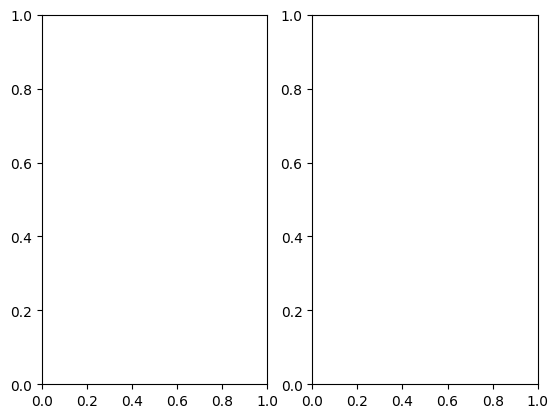

In [7]:

# define device for GPU compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and transform datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and optimizer for the underlying network
model_inner = SimpleRNet()
optimizer_inner = optim.Adam(model_inner.parameters(), lr=1e-3)
# now wrap the network in the LRP class
model_outer = WrapperNet(SimpleRNet())
optimizer_outer = optim.Adam(model_outer.parameters(), lr=1e-6)

# define the loss functions for each
criterion_outer = CosineDistanceLoss()
criterion_inner = nn.CrossEntropyLoss()

# Move to device
model_inner.to(device)
model_outer.to(device)

EPOCHS = 100
OUTER_TRAIN_FREQ = 1
VISUALIZE_FREQ = 5
for x in range(EPOCHS):
    # syncronise parameters to get latest params from outer model
    # so that we can train the inner model
    model_inner.load_state_dict(model_outer.model.state_dict())
    inner_train_loss  = train_inner_model(model_inner, optimizer_inner, criterion_inner, train_loader, device)
    inner_test_loss, inner_accuracy = test_inner_model(model_inner, criterion_inner, test_loader, device)
    print(f"Epoch {x} Inner Test Loss: {inner_test_loss}; Inner Accuracy: {inner_accuracy}; Inner Train Loss: {inner_train_loss}")
    # make sure to then upload these into the outer model
    # so that we can then train the outer model and see the changes tthat h
    model_outer.model.load_state_dict(model_inner.state_dict())
    if x % OUTER_TRAIN_FREQ == 0:
        # belt and braces approach sync parameters again
        model_outer.model.load_state_dict(model_inner.state_dict())
        outer_train_loss = train_outer_model(model_outer, optimizer_outer, criterion_outer, train_loader, device, apply_threshold)
        print(f'Epoch {x} Outer Train Session')
        print(f'Epoch {x} Outer Train Loss: {outer_train_loss}')
        inner_test_loss, inner_accuracy = test_inner_model(model_outer.model, criterion_inner, test_loader, device)
        prev_test_loss, prev_inner_accuracy = test_inner_model(model_inner, criterion_inner, test_loader, device)
        print(f"Epoch {x} Inner Test Loss pre outer training: {prev_test_loss} Inner Accuracy pre outer training: {prev_inner_accuracy}")
        print(f"Epoch {x} Inner Test Loss post outer training: {inner_test_loss} Inner Accuracy post outer training: {inner_accuracy}")
        print(f"Epoch {x}: Inner Loss Delta {inner_test_loss - prev_test_loss}; Inner Accuracy Delta {inner_accuracy - prev_inner_accuracy}")
        # finally sync params at end of outer training loop
        model_inner.load_state_dict(model_outer.model.state_dict())
    if x % VISUALIZE_FREQ == 0:
        plot_heatmap_comparison(model_outer, test_loader, device, apply_threshold, x)